
# Pruned Exact Linear Time (PELT) Test in Multiple Changepoint Detection 

Статья - https://arxiv.org/pdf/1101.1438.pdf

In [1]:
import sys
# sys.path.append(
#     "../"
# )

import numpy as np
import pandas as pd
from scipy.stats import expon
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src.pelt import pelt
from src.utils import display

# Пример на наших игрушечных

In [2]:
x1 = np.arange(0, 50, 0.1)
x2 = np.arange(50, 100, 0.1)

location_shift = np.concatenate((
        np.random.normal(loc=0.0, size=len(x1)), 
        np.random.normal(loc=5.0, size=len(x2))))

scale_shift = np.concatenate((
        np.random.normal(loc=0.0, scale=1.0, size=len(x1)), 
        np.random.normal(loc=0.0, scale=4.0, size=len(x2))
    ))

seasonality_shift = np.concatenate((
        np.sin(x1) + np.random.normal(loc=0.0, scale=.2, size=len(x1)), 
        np.sin(x2/2) + np.random.normal(loc=0.0, scale=.2, size=len(x2)))
    )

shifts = [location_shift, scale_shift, seasonality_shift]

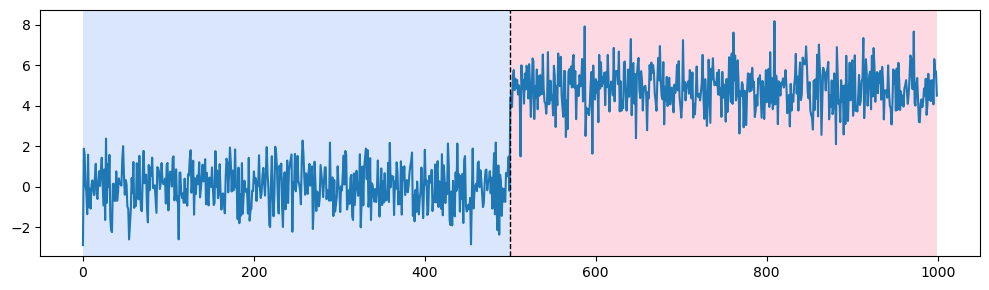

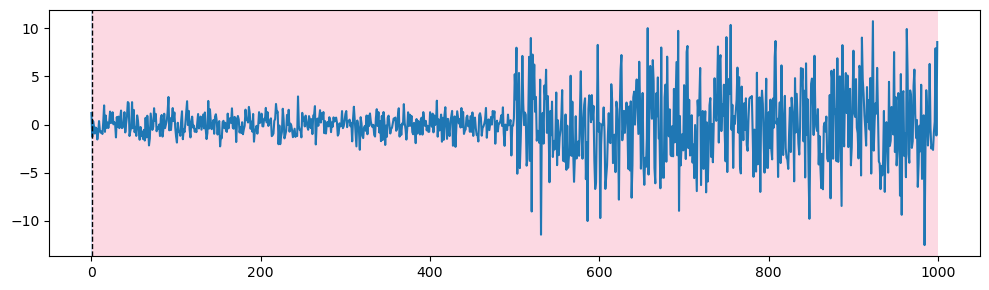

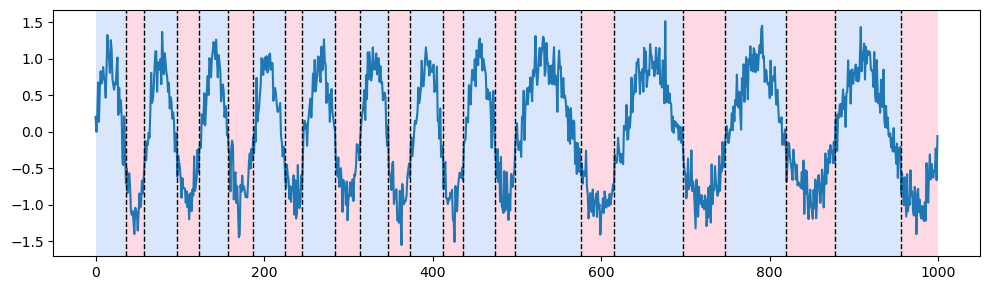

In [3]:
model = "ar"  # Объявляем модель

for shift in shifts:
    length = len(shift)
    bkps = pelt(shift+np.abs(shift.min()), pen=np.log(np.log(length)))  # Какой penalty выбрать?
    bkps.append(length)
    bkps.pop(0)
    # show results
    display(shift, bkps, bkps, figsize=(10, 3))

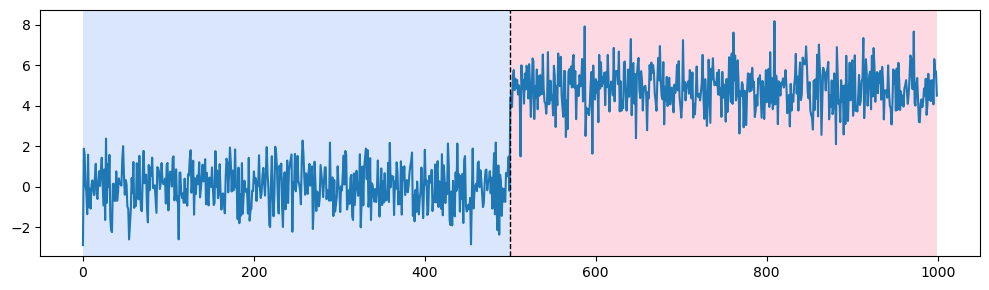

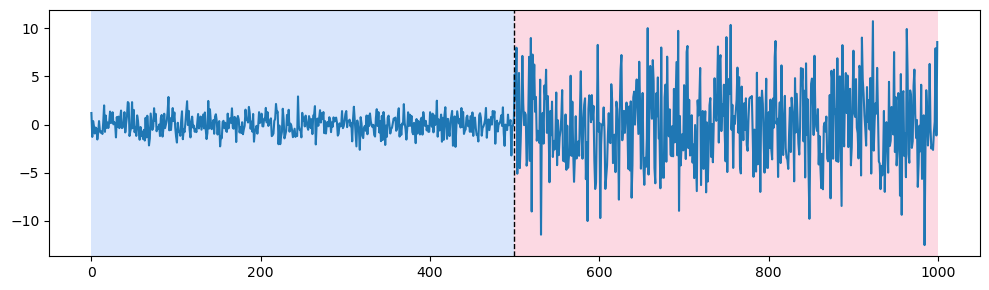

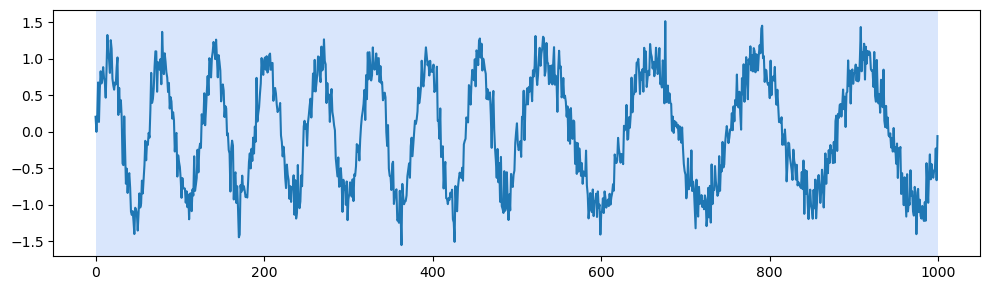

In [4]:
model = "l2"

for shift in shifts:
    length = len(shift)
    bkps = pelt(shift**2, pen=length/2)
    bkps.append(length)
    bkps.pop(0)
    # show results
    display(shift, bkps, bkps, figsize=(10, 3))

# Пример на боевых

In [3]:
activity_data = pd.read_csv("data/day_data.csv")
activity_data.rename(columns={'ring_met':'met'}, inplace=True)

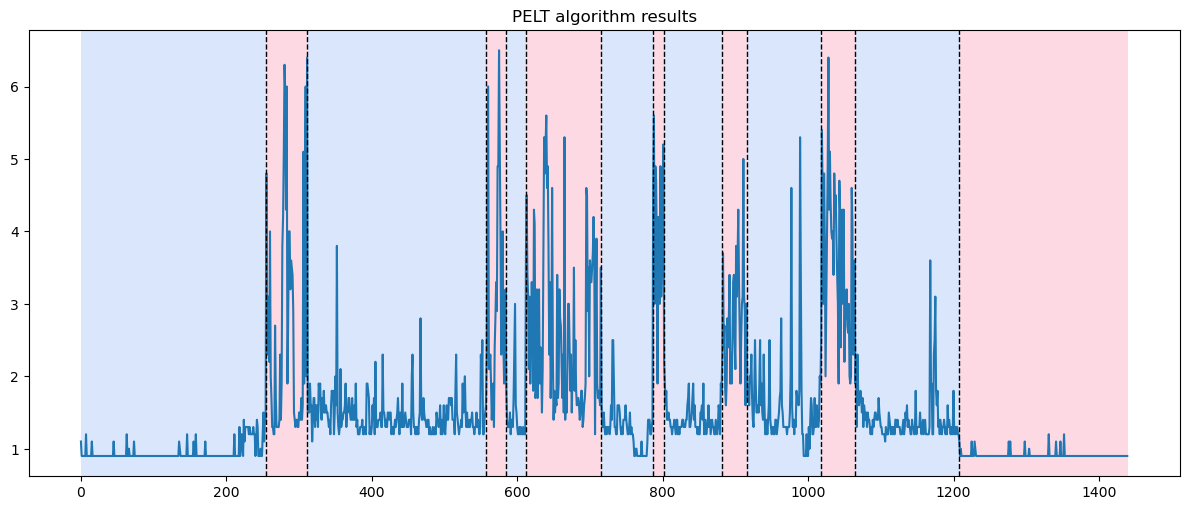

In [4]:
length = len(activity_data)
bkps = pelt(activity_data.met, pen=np.log(np.log(720)))
bkps.append(length)
bkps.pop(0)

display(activity_data.met, bkps, bkps, figsize=(12, 5), linewidth=0.1)
plt.title("PELT algorithm results")
# plt.savefig('../Presentation/img/real_segmented.png')
plt.show()

Основные шаги алгоритма такие же, как и в методе оптимального разделения(optimal partitioning, Jackson et al., 2005) - мы устанавливаем функцию "стоимости" для сегмента, затем перебираем все возможные начальные / конечные точки сегмента и проверяем, даёт ли разделение на новые сегменты уменьшение значения функции стоимости по сравнению с сегментом без разделения.

Общая форма функции потерь:

$$\mathcal{L}=\sum_{i=1}^{m+1}\big[ C(y_{(\tau_{i-1}+1):\tau_i})+\beta \big]$$

где $C$ - функция стоимости сегмента, $\tau_i$ - changepoint, $m$ - общее количество точек изменения, $\beta$ - регуляризатор (penalty) для предотвращения оверфита

$$C(y_{(t+1):s})=-\max_{\theta}\sum_{i=t+1}^s \log f(y_i|\theta)$$

Итак, мы пытаемся найти такое множество разбиения $\tau$ из $m$ точек, которое приведет к наименьшей сумме стоимостей сегментов.

В исходном алгоритме оптимального разделения, который не использует прунинг, задача минимизации итеративно решается с помощью рекурсии. Можно показать, что стоимость оптимальной сегментации шага t + 1 зависит от стоимости оптимальной сегментации шага t (при этом стоимость сегментации шага 0 просто установлена равной -β).

На каждой итерации t алгоритм пытается найти точку перехода между текущей точкой и концом ряда. Для этого он вычисляет функции стоимостей возможных разделов [(start, start + 1), (start, start + 2),…, (start, n-1)], проверяет, дают ли новый локальный минимум какое-либо из разбиений, сумированное со стоимостью всех предыдущих разбивок и регуляризации, и если да, то алгоритм добавляет позицию точки изменения к кандидатам.

Все начинается в точке 0, где стоимость разделения - это, по сути, стоимость одного большого сегмента - полного временного ряда. Затем алгоритм начинает итерацию от точки 1 до конца временного ряда, каждый раз вычисляя стоимость разделения. В конце концов, он находит такую точку, которая минимизирует итоговую стоимость разделения, и запоминает ее. Обратите внимание, что эта точка может лежать в диапазоне от 1 до n-1, где n - длина ряда. Найдя такую точку, алгоритм затем продолжает поиск с новой начальной точки, снова идет до конца ряда, вычисляет стоимость разделения, но на этот раз он использует уже рассчитанную оптимальную стоимость разделения из предыдущего шага. Операция повторяется до тех пор, пока не будут проверены все потенциальные отправные точки.

Как это выглядит после тестирования всех начальных точек: на верхнем графике указана стоимость разделения в момент времени t, учитывая, что предыдущие точки уже были оптимально разделены.

Можно заметить, что начальная точка 0 имеет наивысшую стоимость, то есть, по сути, это стоимость полного несегментированного временного ряда. Затем у нас есть первая оптимальная точка разделения около 120. Кстати, если бы регуляризация была ниже, алгоритм также установил бы точку разделения около 100 (время пробуждения). Все последующие точки разделения также уменьшают общую стоимость.

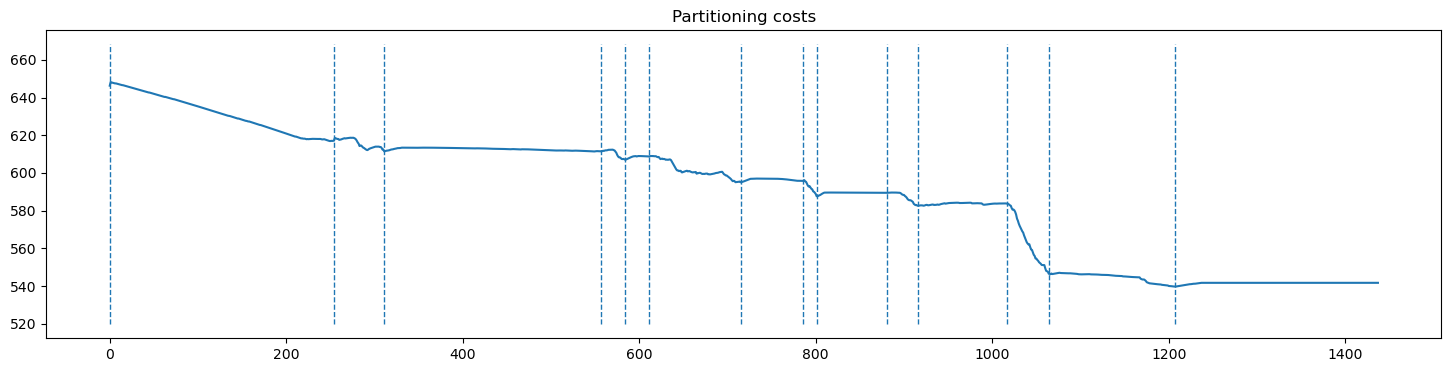

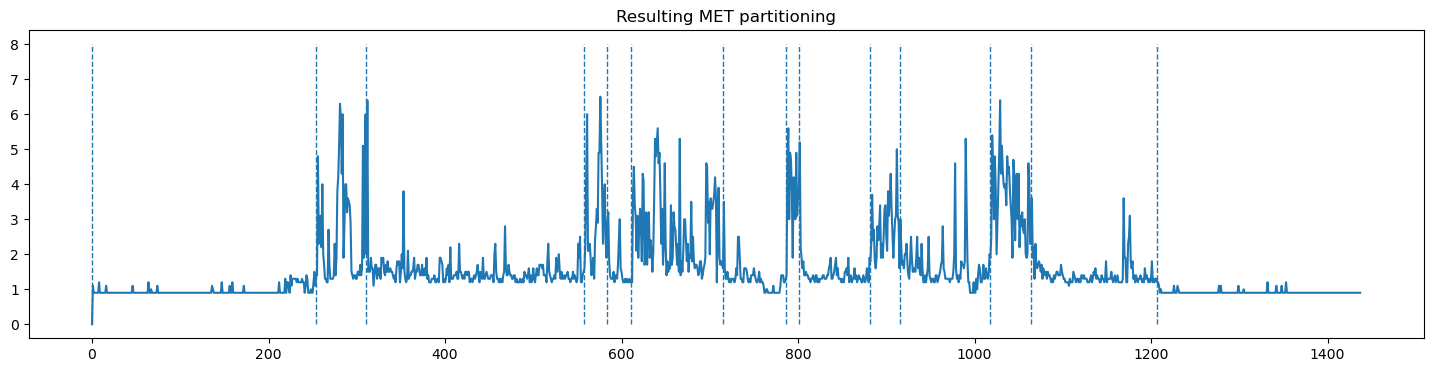

In [5]:
length = len(activity_data)-1
data = np.hstack(([0.0], np.array(activity_data.met.values)))
cumm = np.cumsum(activity_data.met.values)

pen = np.log(np.log(1440))

# F[t] is optimal cost of segmentation upto time t
F = np.zeros(length + 1)
F[0] = -pen

# last changepoint prior to time t
R = np.array([0], dtype=int)

# vector of candidate changepoints at t
candidates = np.zeros(length + 1, dtype=int)

for tstar in range(2, length + 1):
    cpt_cands = R
    seg_costs = -1*(tstar-cpt_cands)*(np.log(tstar-cpt_cands)-np.log(cumm[tstar]-cumm[cpt_cands]))            
    F_cost = F[cpt_cands] + seg_costs
    F[tstar], tau = min(F_cost) + pen, np.argmin(F_cost)
    candidates[tstar] = cpt_cands[tau]

    # pruning step
    #ineq_prune =  F_cost < F[tstar] 
    R = list(cpt_cands) 
    R.append(tstar - 1)
    R = np.array(R, dtype=int)  

# get changepoints
last = candidates[-1]
changepoints = [last]
while last > 0:
    last = candidates[last]
    changepoints.append(last)
    
plt.figure(figsize=(18, 4))
plt.plot(cpt_cands, F_cost)
plt.vlines(sorted(changepoints), min(F_cost)-20, max(F_cost)+20, linewidth=1, linestyles='--')
plt.title("Partitioning costs")

plt.figure(figsize=(18, 4))
plt.title("Resulting MET partitioning")
plt.plot(cpt_cands, data[cpt_cands])
plt.vlines(sorted(changepoints), 0, 8, linewidth=1, linestyles='--')

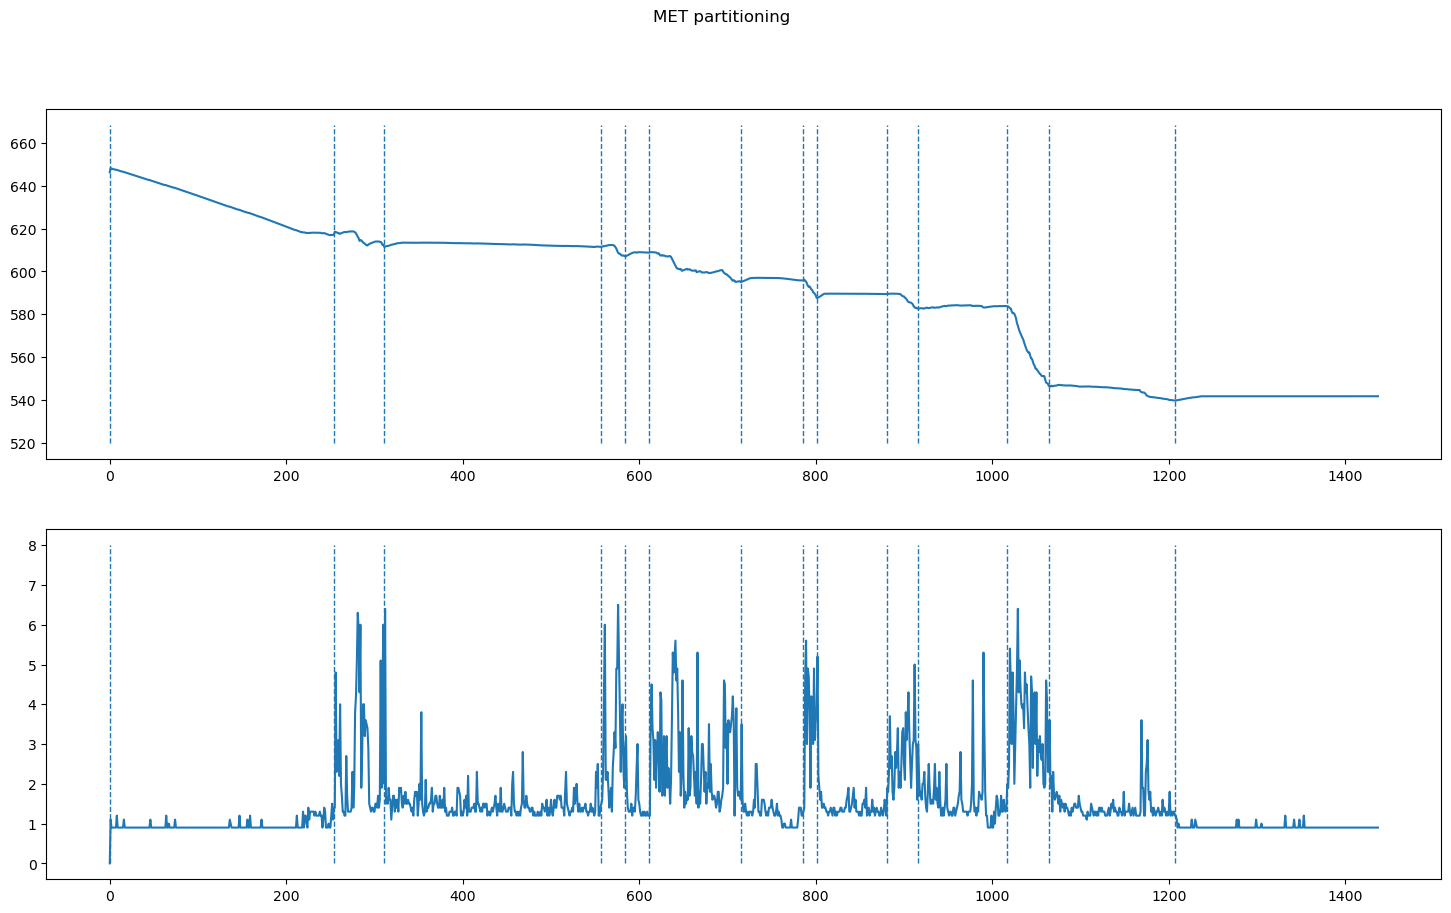

In [6]:
fig, axs = plt.subplots(2, figsize=(18, 10))
fig.suptitle('MET partitioning')
axs[0].plot(cpt_cands, F_cost)
axs[0].vlines(sorted(changepoints), min(F_cost)-20, max(F_cost)+20, linewidth=1, linestyles='--')

axs[1].plot(cpt_cands, data[cpt_cands])
axs[1].vlines(sorted(changepoints), 0, 8, linewidth=1, linestyles='--')
# fig.savefig('../Presentation/img/MET.png')
plt.show()

Единственные предпосылки метода:

- Мы детектируем структурные сдвиги (то есть смещение среднего значения)
- Данные распределены экспоненциально

С первым полный порядок, второе можно проверить:

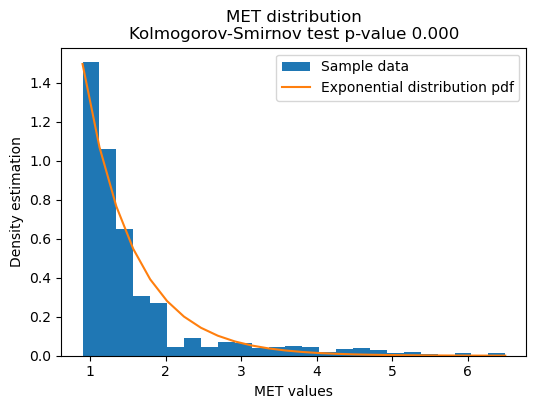

In [9]:
clean_data = activity_data.met[activity_data.met>0.1]

loc, scale = expon.fit(clean_data)

ks_test = stats.kstest(activity_data.met, expon.cdf, (loc, scale))

plt.figure(figsize=(6, 4))
bins = plt.hist(clean_data, density=True, bins=25, label="Sample data")
plt.plot(bins[1], expon.pdf(bins[1], loc=loc, scale=scale), label="Exponential distribution pdf")
plt.title(f"MET distribution\nKolmogorov-Smirnov test p-value {ks_test.pvalue:.3f}")
plt.ylabel("Density estimation")
plt.legend()
plt.xlabel("MET values")
plt.show()

# Финальный акорд. Подберем регуляризацию.

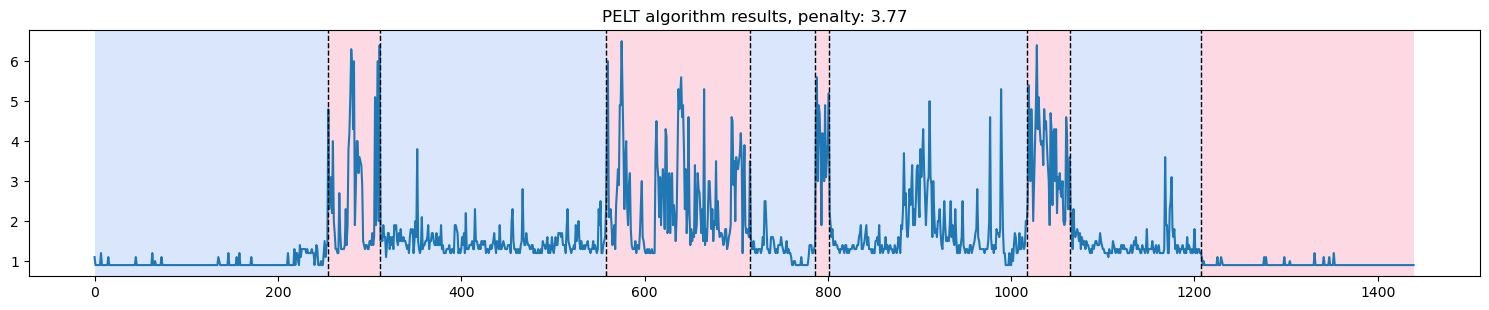

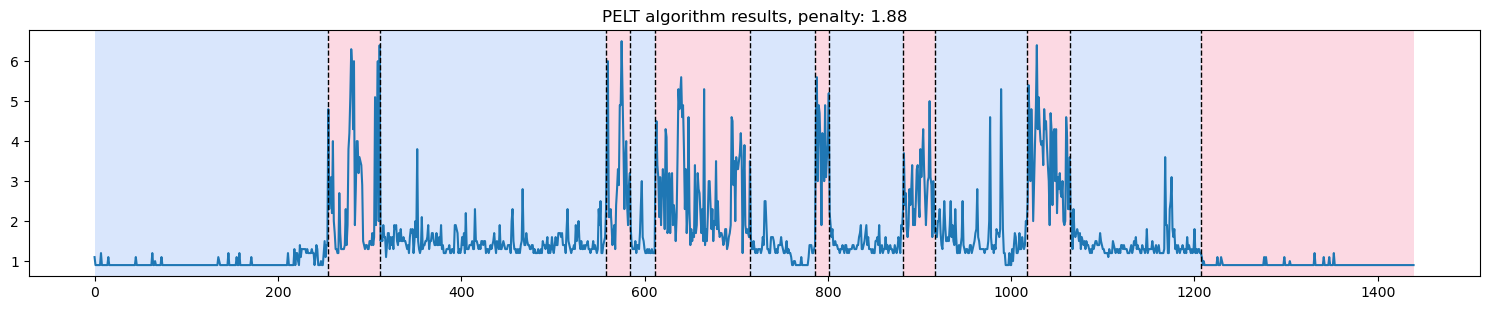

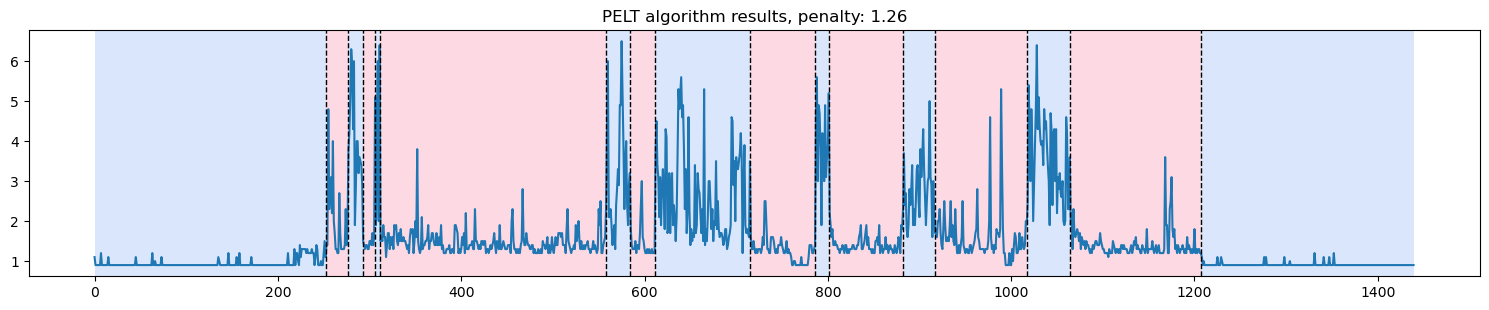

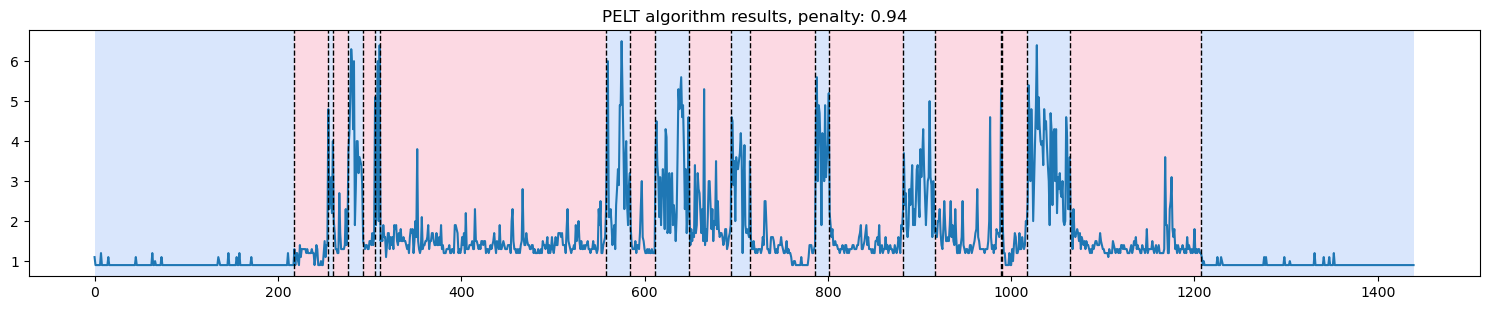

In [10]:
for i in np.arange(0.5, 2.5, 0.5):

    length = len(activity_data)
    bkps = pelt(activity_data.met, pen=np.log(np.log(720))/i)
    bkps.append(length)
    bkps.pop(0)

    display(activity_data.met, bkps, bkps, figsize=(15, 3), linewidth=0.1)
    plt.title(f"PELT algorithm results, penalty: {round(np.log(np.log(720))/i, 2)}")
    plt.show()